In [2]:
import numpy as np
import pandas as pd
import polars as pl # DataFrame
import polars.selectors as cs # polarsのサブモジュール
pl.Config.set_fmt_str_lengths(100) # print, displayの表示制限調整
from datetime import date
import jpholiday

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [26, 18]

In [3]:
train_df = pd.read_csv('/Users/estyle-150/github/my_signage/data/raw/train.csv')
test_df = pd.read_csv('/Users/estyle-150/github/my_signage/data/raw/test.csv')

In [4]:
train_df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


In [5]:
test_df.head()

,datetime,client,close,price_am,price_pm
0,2016-04-01,1,0,3,2
1,2016-04-02,0,0,5,5
2,2016-04-03,1,0,2,2
3,2016-04-04,1,0,1,1
4,2016-04-05,0,0,1,1


In [6]:
print("train:", train_df.shape, " test:", test_df.shape)

train: (2101, 6)  test: (365, 5)


In [7]:
#############################
########### EDA #############
#############################

# 欠損値−１を NaN に変える
train_df[['price_am', 'price_pm']] = train_df[['price_am', 'price_pm']].replace(-1, np.nan)
test_df[['price_am', 'price_pm']] = test_df[['price_am', 'price_pm']].replace(-1, np.nan)

train_df['is_train'] = 1
test_df['is_train'] = 0

train_cols = train_df.columns.tolist() # 列名（カラム名）をリスト形式で取得
test_cols = test_df.columns.tolist()
common_cols = list(set(train_cols) & set(test_cols)) # 共通のカラム
train_only = list(set(train_cols) - set(common_cols))  # 訓練データのみのカラム
test_only = list(set(test_cols) - set(common_cols))    # テストデータのみのカラム

for col in train_only:
    test_df[col] = None

for col in test_only:
    train_df[col] = None

merged_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

pd.set_option('future.no_silent_downcasting', True)
merged_df['y'] = merged_df['y'].fillna(0).astype(int)


merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df['year'] = merged_df['datetime'].apply(lambda x: x.year)
merged_df['month'] = merged_df['datetime'].apply(lambda x: x.month)
merged_df['weekday'] = merged_df['datetime'].apply(lambda x: x.weekday())

merged_df = merged_df.set_index('datetime', inplace=False)
merged_df.corr()

,y,client,close,price_am,price_pm,is_train,year,month,weekday
y,1.000000,-0.020164,-0.165167,0.391781,0.355146,0.600403,0.019557,-0.123845,0.118830
client,-0.020164,1.000000,-0.048251,0.084130,0.087443,-0.351634,0.469240,0.093550,0.048139
close,-0.165167,-0.048251,1.000000,NaN,NaN,-0.002660,0.027550,-0.075355,-0.008984
price_am,0.391781,0.084130,NaN,1.000000,0.885478,-0.008762,0.047024,-0.167561,0.377813
price_pm,0.355146,0.087443,NaN,0.885478,1.000000,-0.024756,0.058797,-0.174833,0.316956
is_train,0.600403,-0.351634,-0.002660,-0.008762,-0.024756,1.000000,-0.604888,0.006277,-0.000487
year,0.019557,0.469240,0.027550,0.047024,0.058797,-0.604888,1.000000,-0.194370,-0.000753
month,-0.123845,0.093550,-0.075355,-0.167561,-0.174833,0.006277,-0.194370,1.000000,-0.001716
weekday,0.118830,0.048139,-0.008984,0.377813,0.316956,-0.000487,-0.000753,-0.001716,1.000000


In [109]:
# 欠損値の確認
l = '============================================'
print('欠損値:')
print('訓練データ')
print(train_df.isnull().sum())
print('テストデータ')
print(test_df.isnull().sum())
print(l)
print('データ型')
print(merged_df.dtypes)
print(l)
print(train_df.describe())

欠損値:
訓練データ
datetime      0
y             0
client        0
close         0
price_am    211
price_pm    212
is_train      0
dtype: int64
テストデータ
datetime      0
client        0
close         0
price_am      5
price_pm      5
is_train      0
y           365
dtype: int64
データ型
y             int64
client        int64
close         int64
price_am    float64
price_pm    float64
is_train      int64
year          int64
month         int64
weekday       int64
dtype: object
                 y       client        close     price_am     price_pm  \
count  2101.000000  2101.000000  2101.000000  1890.000000  1889.000000   
mean     34.096621     0.098049     0.012851     0.794709     0.546850   
std      17.476234     0.297451     0.112658     1.044370     0.903766   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      21.000000     0.000000     0.000000     0.000000     0.000000   
50%      32.000000     0.000000     0.000000     0.500000     0.000000   
75%      45.000

<Axes: >

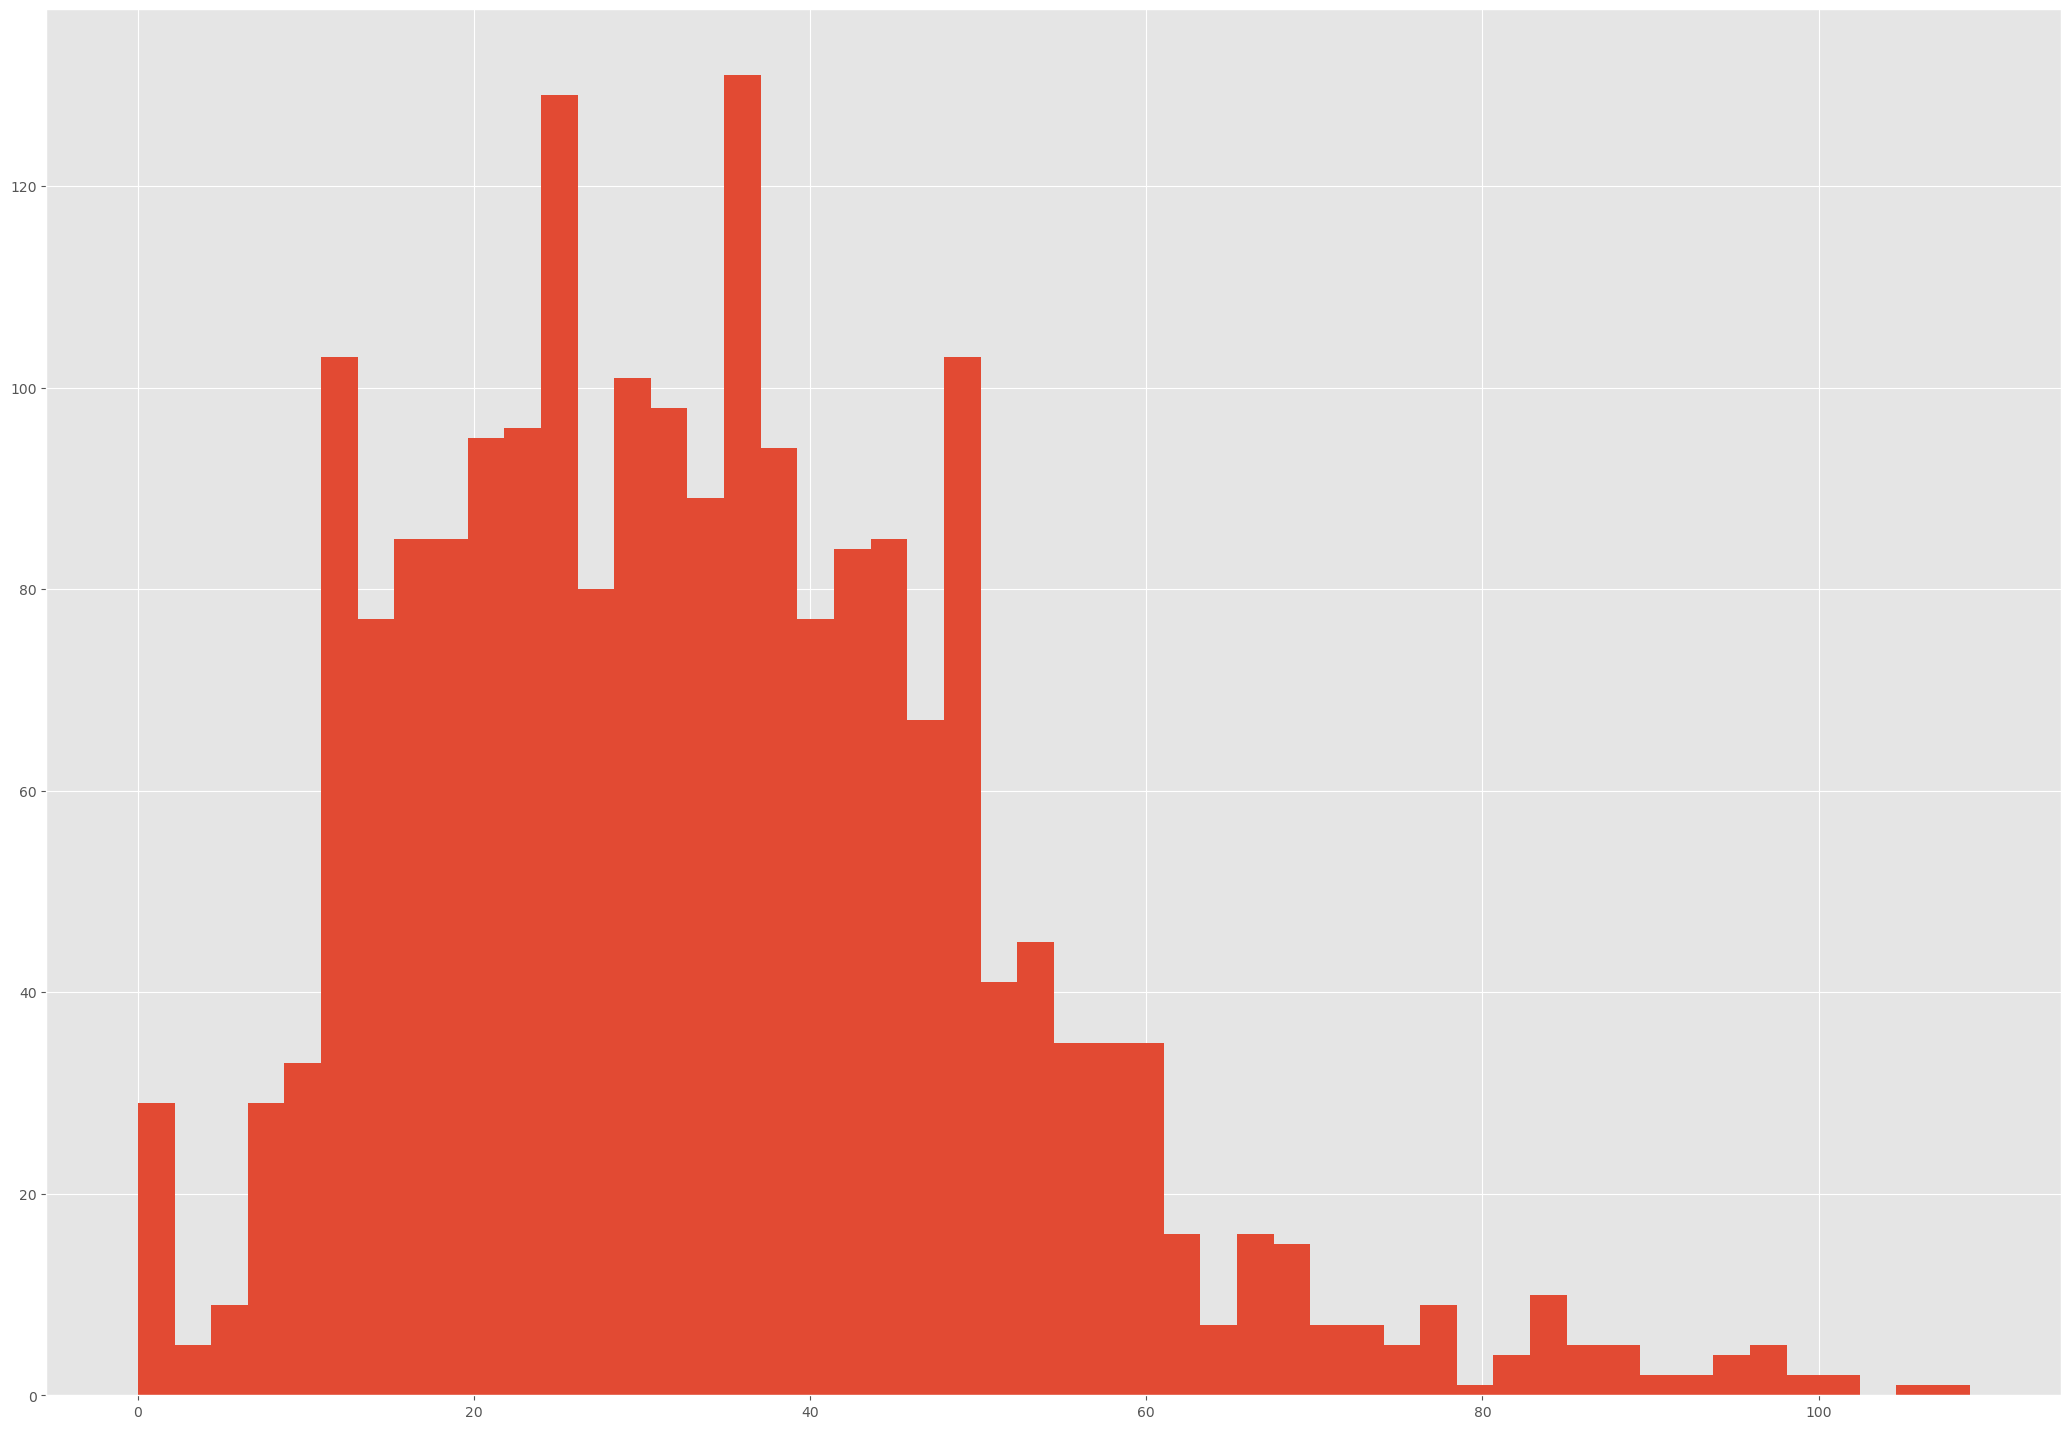

In [110]:
train_df['y'].hist(bins=50)

In [111]:
# yの分布が非対称
# 右裾の重い分布？？

<Axes: >

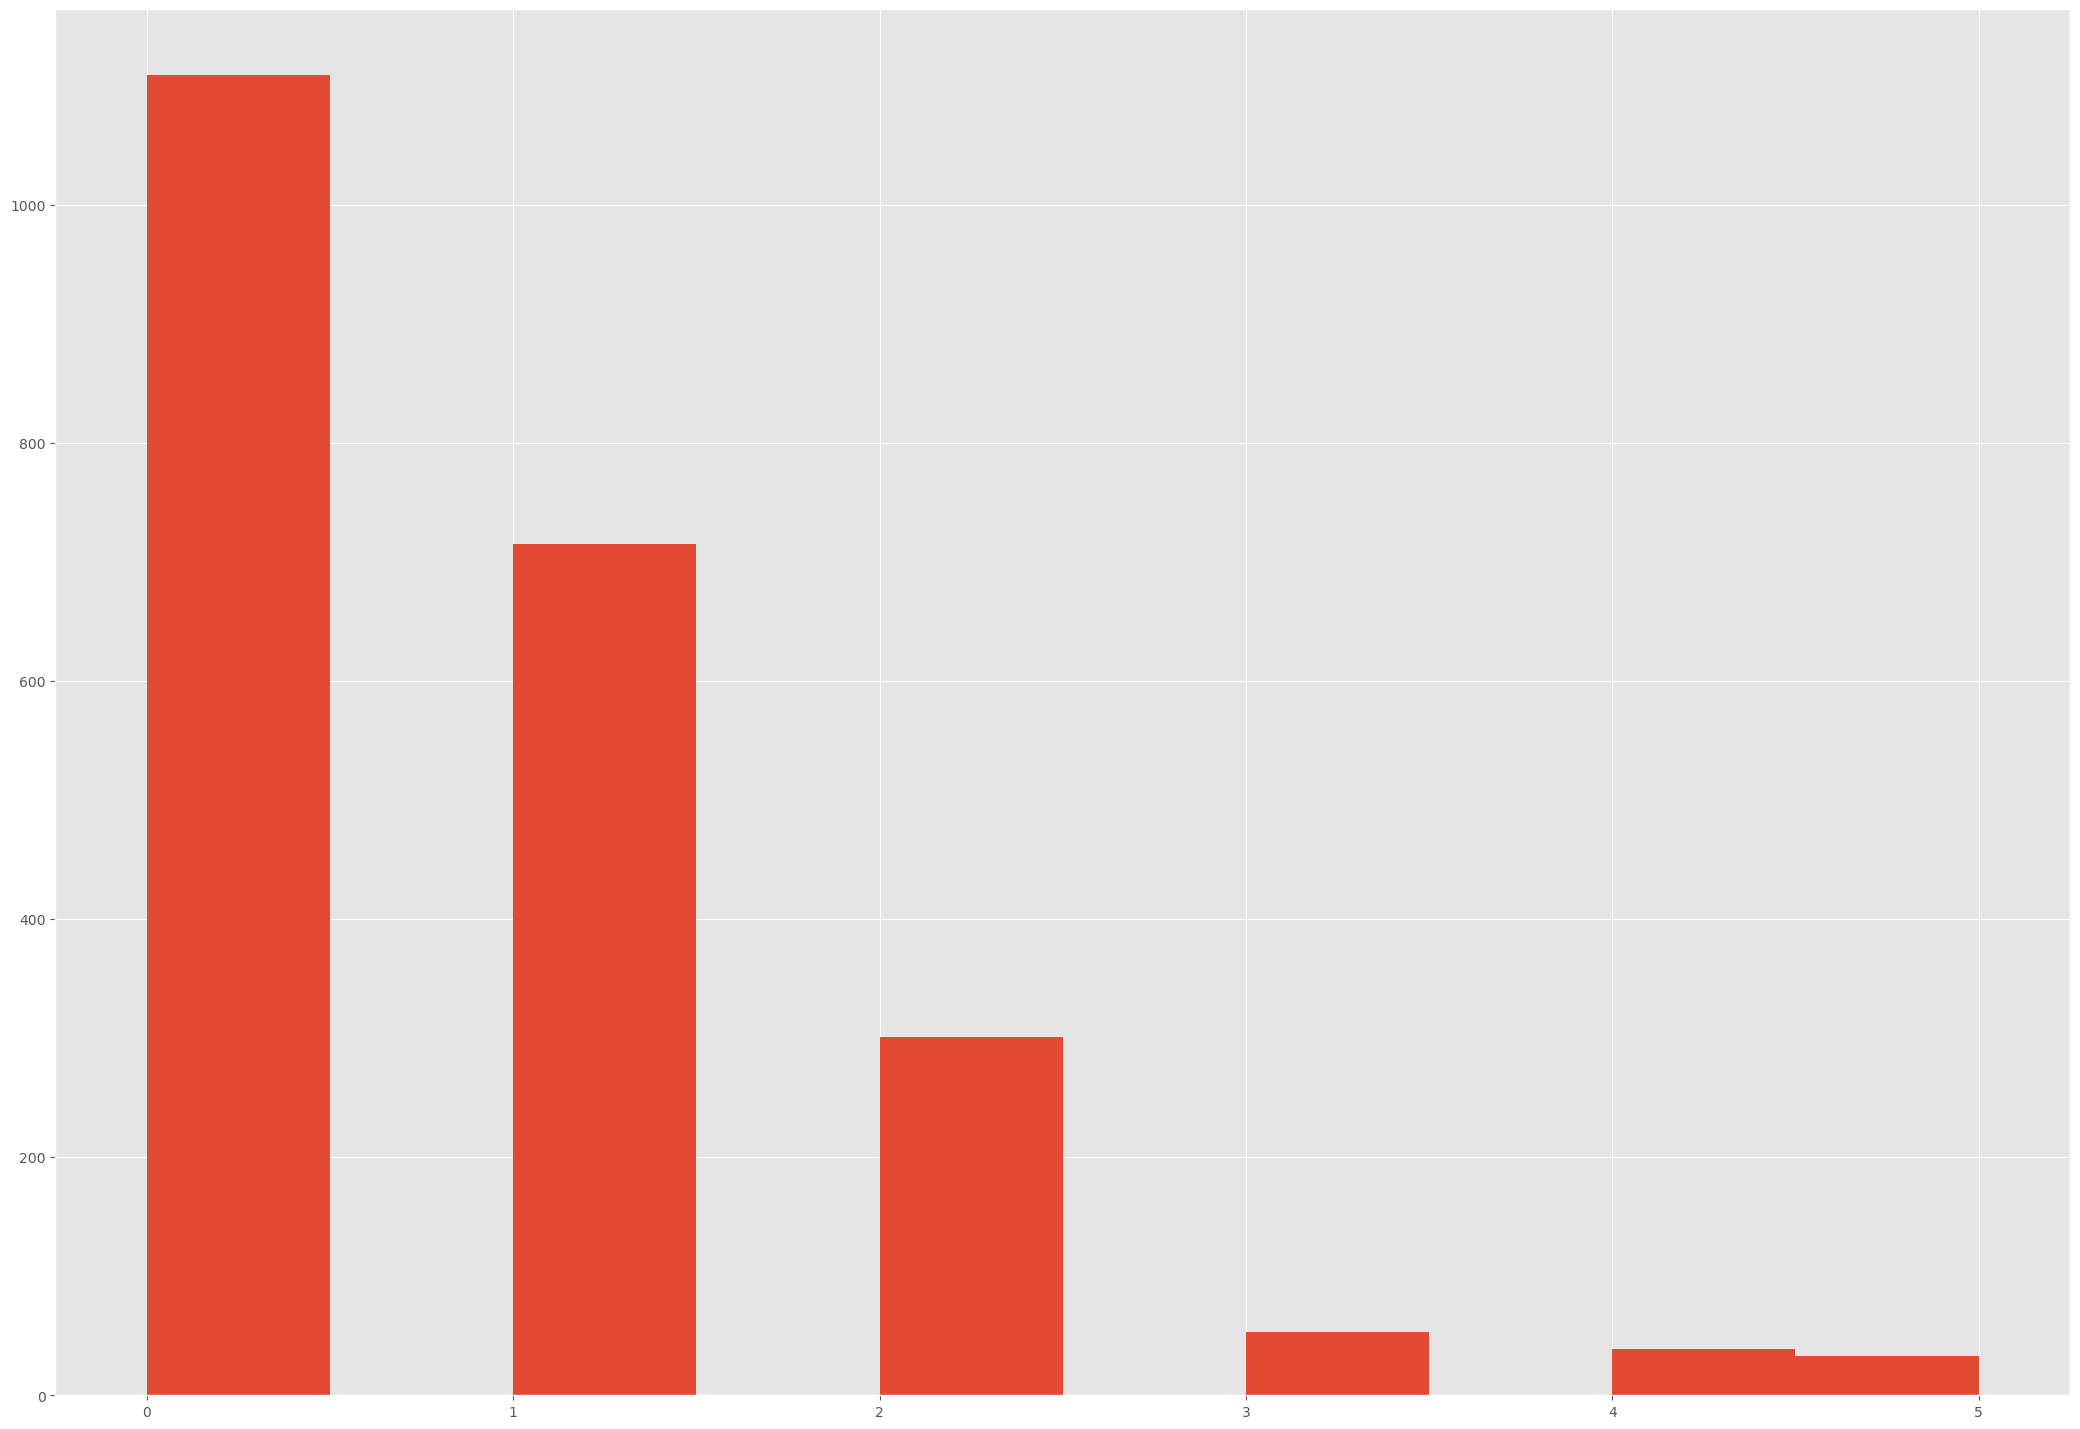

In [112]:
merged_df['price_am'].hist()

In [113]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # データフレーム作成
    adf_df = pd.DataFrame(
        [
            adfuller(series)[1]
        ],
        columns=['P値']
    )
    # 有効数字3桁にする
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

adf_test(series=train_df['y'])

      P値
0  0.575


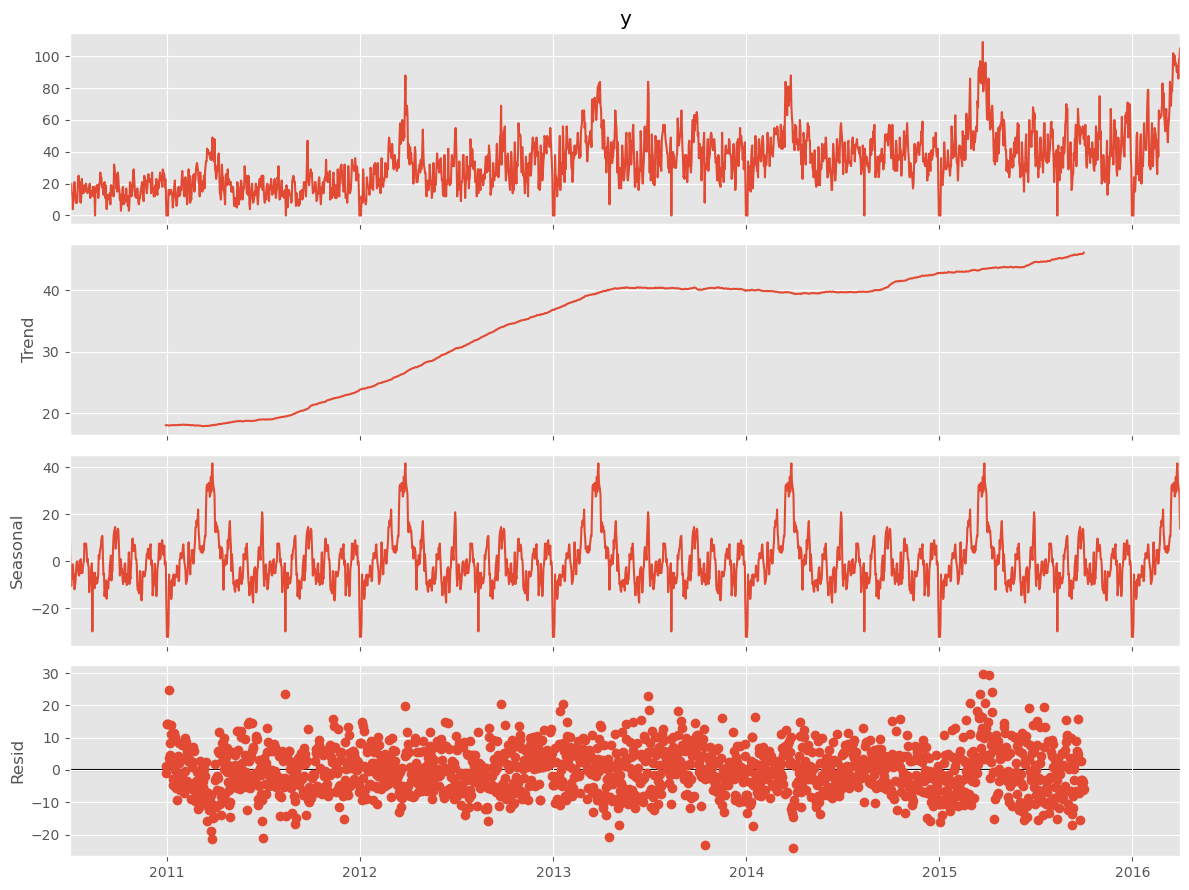

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 訓練データに対して季節性、トレンドの確認
price_am_seasonal = seasonal_decompose(merged_df[merged_df['is_train']==1].y, model='additive', period=365)

# 分解結果のプロット
fig = price_am_seasonal.plot()
plt.show()

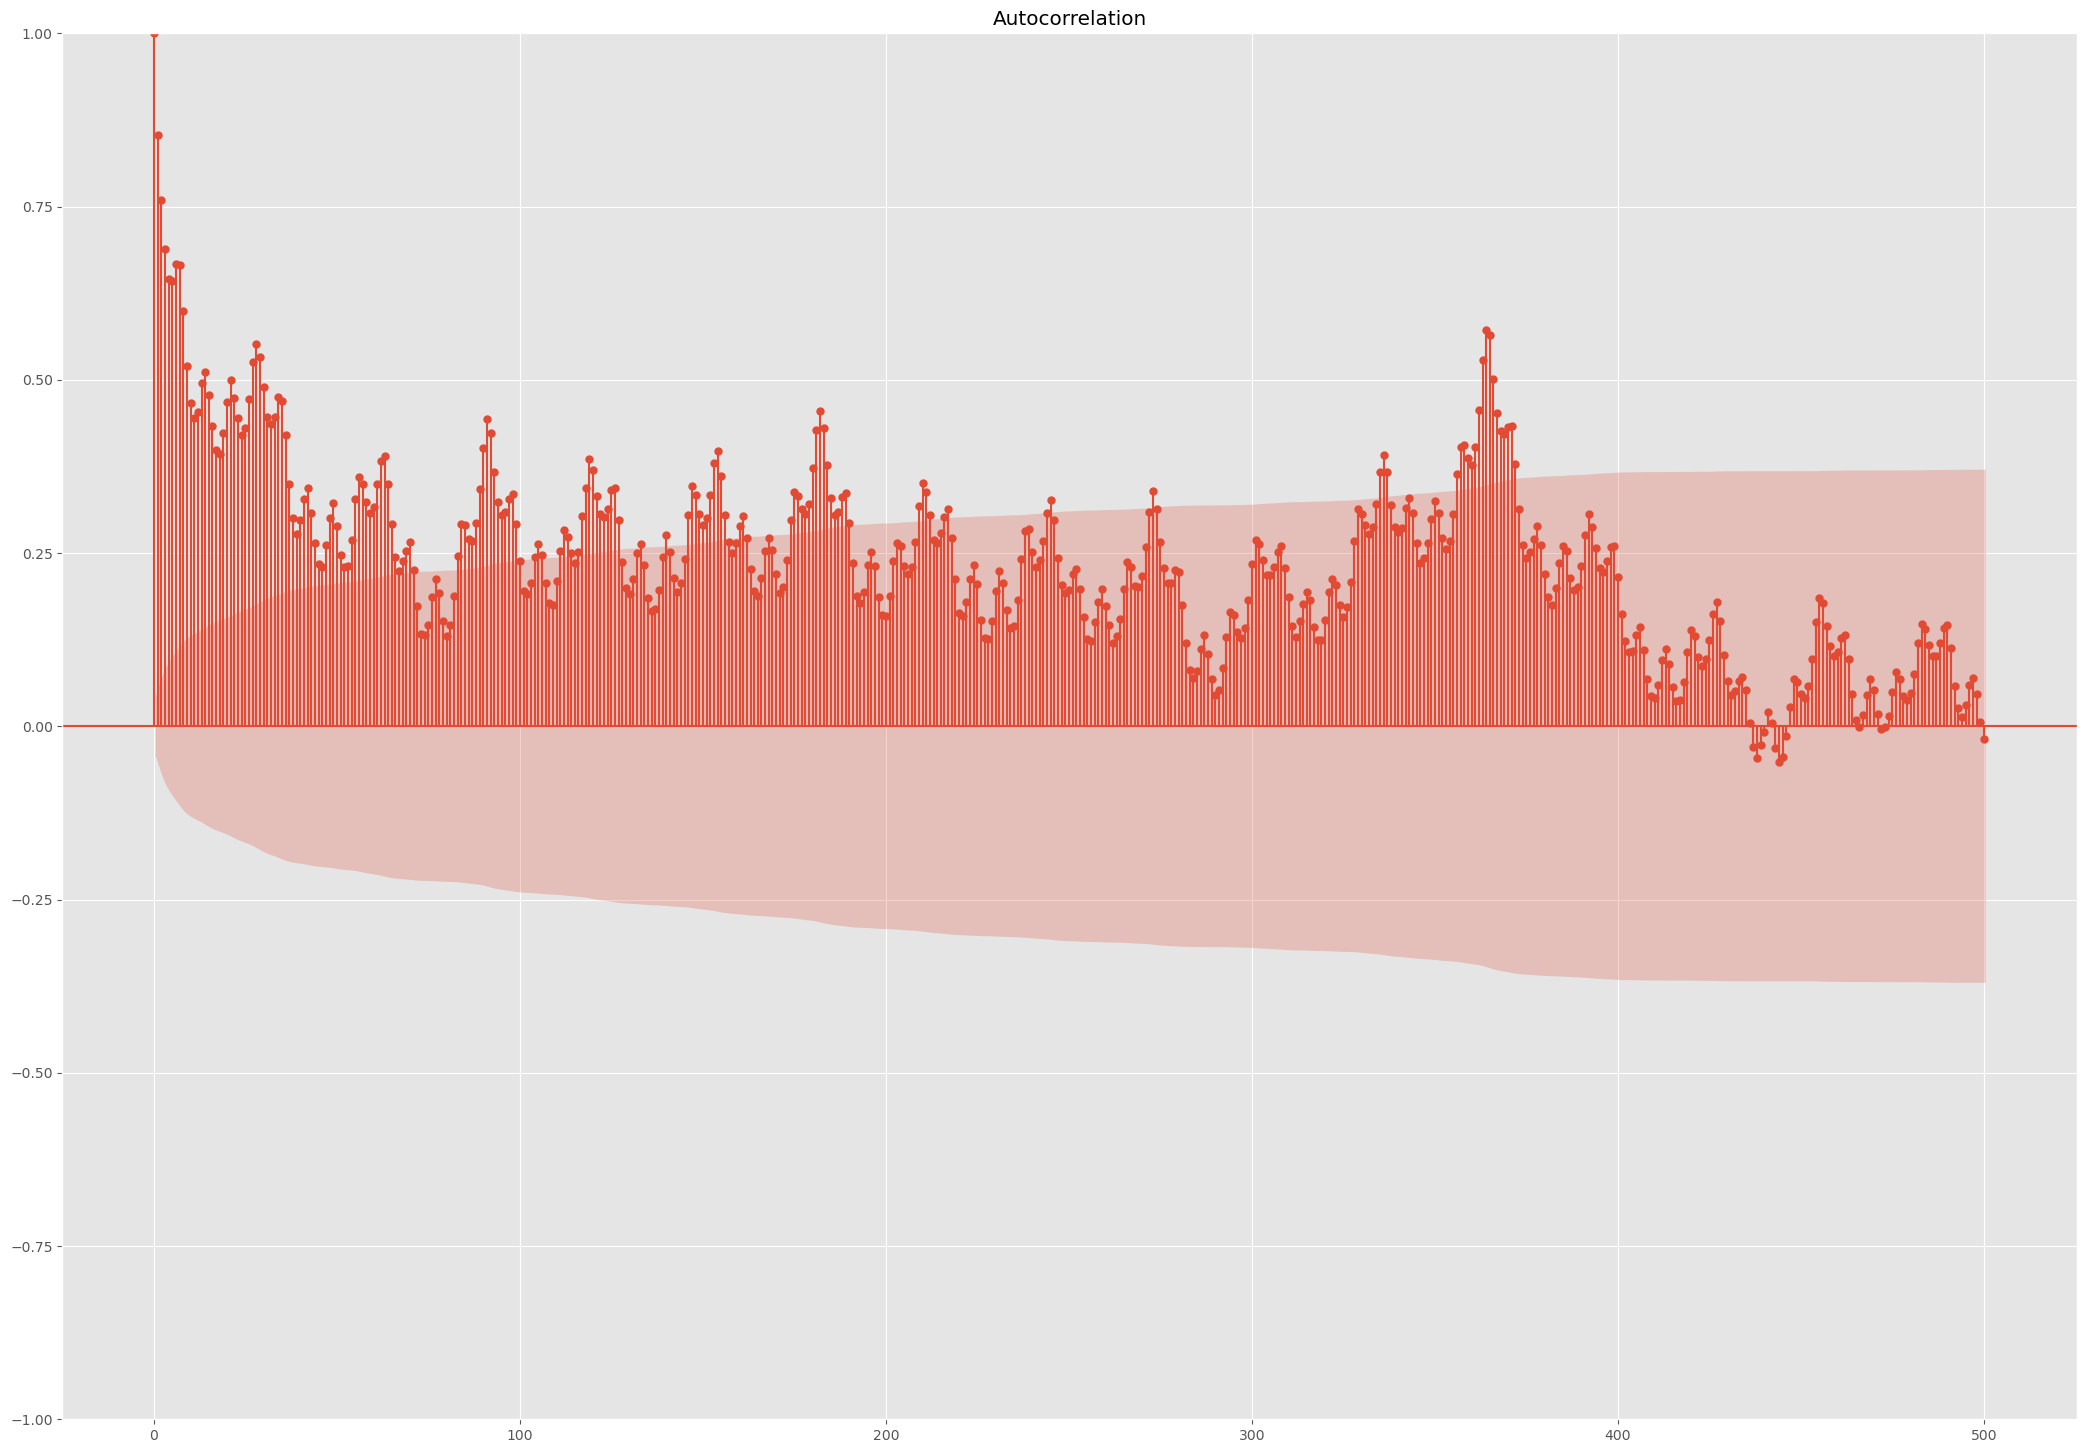

In [114]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_df['y'], lags=500)
plt.show()

In [115]:
import ruptures as rpt
from ruptures.metrics import precision_recall

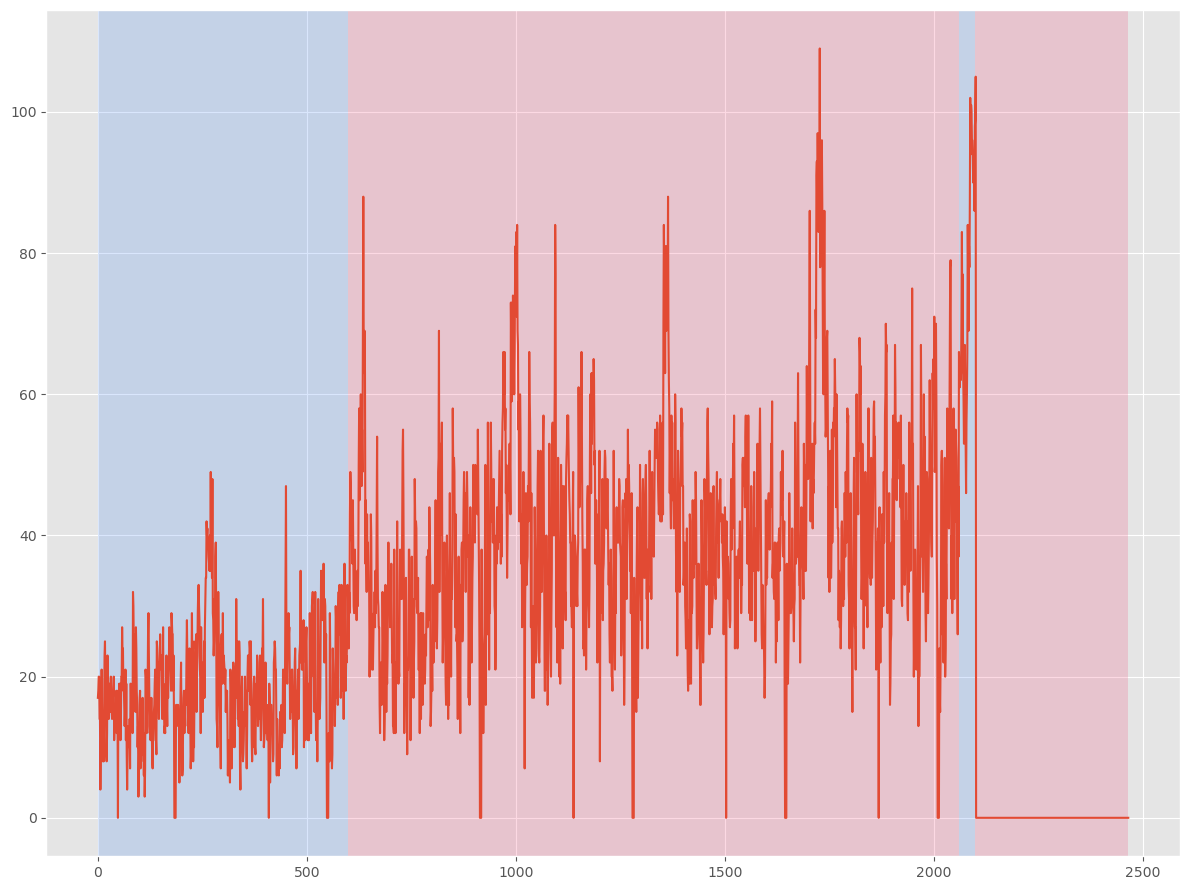

[600, 2060, 2100, 2466]


In [116]:
################
### 変化点検知 ###
################

# コスト関数の設定
model = "l2"

# アルゴの設定と学習
algo = rpt.Dynp(model=model).fit(merged_df[['y']])

# 変化点の検出
my_bkps = algo.predict(n_bkps=3)

# 結果のプロット
rpt.show.display(merged_df[['y']], my_bkps, figsize=(12, 9))
plt.show()

# 検出された変化点
print(my_bkps)

In [ ]:
### 特徴量作成 ###
